<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
!nvidia-smi

Sun Feb  7 08:22:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 108kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Новый раздел

In [4]:
!tar -xvf  '/content/gdrive/MyDrive/handout.tar' -C '/content'

data/
data/captions_tokenized.json
data/image_codes.npy


In [5]:
!unzip -q '/content/gdrive/MyDrive/test_images.zip' -d '/content' # flickr dataset

In [6]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [7]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [8]:
from collections import Counter

class WordsCounter:

    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.num_words = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

class Vocabulary:

    def __init__(self):
        SOS_token = 0
        EOS_token = 1
        PAD_token = 2
        self.words = set(['<SOS>', '<EOS>', '<PAD>'])
        self.word2index = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2}
        self.index2word = {SOS_token: "<SOS>", EOS_token: "<EOS>", PAD_token: "<PAD>"}
        self.num_words = 3

    def add_word(self, word):
        self.words.update([word])
        self.word2index[word] = self.num_words
        self.index2word[self.num_words] = word
        self.num_words += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

    def size(self):
        return self.num_words

In [9]:
words_counter = WordsCounter()

for sentences in captions:
    for sentence in sentences:
        words_counter.add_sentence(sentence)    
word2count_dict = words_counter.word2count

In [12]:
vocab = Vocabulary()

for k, v in word2count_dict.items():
    if v >= 5:
        vocab.add_word(k)

In [13]:
from torch.utils.data import Dataset, random_split
import torch
import numpy as np
import math

# Для воспроизводимости результатов
SEED = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)


class COCODataset(Dataset):
    def __init__(self, vocab, word2index, index2word, images, captions, max_len=35):
        self.vocab = vocab
        self.max_len = max_len
        self.word2index = word2index
        self.index2word = index2word

        self.images = images
        self.captions = captions

    def __getitem__(self, item):
        
        image = self.images[item]
        num_of_captions = len(self.captions[item])
        rand_num_of_caption = np.random.randint(num_of_captions)
        selected_caption = self.captions[item][rand_num_of_caption]

        caption = [0]   # SOS token
        for word in selected_caption.split(' '):
            if len(caption) >= self.max_len:    
                caption[-1] = 1
                break
            if word in self.vocab:
                caption.append(self.word2index[word])
        if caption[-1] != 1:
            caption.append(1)   # EOS token

        return {
            'image_emb': image,
            'caption': caption
        }

    def __len__(self):
        return len(self.captions)

In [14]:
import os
import glob
from PIL import Image
from scipy.misc import imresize

class TestDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.imgs = list(sorted(glob.glob(os.path.join(root + '/*.jpg'))))

    def __getitem__(self, item):
        img_path = os.path.join(self.root, self.imgs[item])
        img = Image.open(img_path).convert("RGB")
        img = np.asarray(img)
        img = imresize(img, (299, 299)).astype('float32') / 255.
        
        return img

    def __len__(self):
        return len(self.imgs)

In [15]:
test_images_DIR = '/content/test_images'

test_dataset = TestDataset(test_images_DIR)
dataset = COCODataset(vocab.words, vocab.word2index, vocab.index2word, img_codes, captions)

train_size = int(.8 * len(dataset))
train_data, valid_data = random_split(dataset, [train_size, len(dataset)-train_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of valid examples: {len(valid_data)}")
print(f"Number of test examples images: {len(test_dataset)}")

Number of training examples: 94629
Number of valid examples: 23658
Number of test examples images: 3353


In [16]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = []
    captions = []

    for elem in batch:
        images.append(elem['image_emb'])
        captions.append(elem['caption'])

    captions = get_padded(captions) # padded inputs

    return {'images_emb': torch.FloatTensor(images), 'captions': torch.tensor(captions)}

def get_padded(inputs):
    max_len = 0
    for input in inputs:
        if len(input) > max_len:
            max_len = len(input)

    padded = np.array([input + [2]*(max_len-len(input)) for input in inputs])
    return padded

train_loader = DataLoader(train_data, batch_size=256, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=256, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [17]:
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [19]:
class CaptionNet(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, num_layers=2, encoder_dim=2048, dropout=0.4):
        super(self.__class__, self).__init__()


        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов


        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.linear_h = nn.ModuleList([nn.Linear(encoder_dim, decoder_dim) for _ in range(num_layers)])
        self.linear_c = nn.ModuleList([nn.Linear(encoder_dim, decoder_dim) for _ in range(num_layers)])
        self.embedding = nn.Embedding(vocab_size, embed_dim) 

        self.rnn = nn.LSTM(embed_dim, decoder_dim, 
                           num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        
    def forward(self, images, captions):
        """ 
        Apply the network in training mode. 
        :param images: torch tensor, содержащий выходы inception. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions: 
                ground truth описание на котором обучаемся
                shape: [batch, max_seq_len]
        :returns: логиты для сгенерированного текста описания,
                shape: [batch, word_i, n_tokens]
        """
        
        h_states = []
        c_states = []
        for h, c in zip(self.linear_h, self.linear_c):
            h_states.append(h(images))
            c_states.append(c(images))
        init_h0 = torch.stack(h_states, dim=0)
        init_c0 = torch.stack(c_states, dim=0)
        hidden = (init_h0, init_c0)
        
        captions_emb = self.dropout(self.embedding(captions))

        output, hidden = self.rnn(captions_emb, hidden)
        output = self.fc(output)

        return output

    def inference(self, images, max_len=35):
        """
        :param images: torch tensor, содержащий выходы inception. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param max_len: максимальная длина генерируемого описания
        :returns: логиты для каждого изображения в батче
        """

        batch_size = images.size(0)

        outputs = torch.zeros(batch_size, max_len, self.vocab_size).cuda()

        input = torch.zeros(batch_size, 1, dtype=torch.long).cuda()
        input = self.embedding(input)

        h_states = []
        c_states = []
        for h, c in zip(self.linear_h, self.linear_c):
            h_states.append(h(images))
            c_states.append(c(images))
        init_h0 = torch.stack(h_states, dim=0)
        init_c0 = torch.stack(c_states, dim=0)
        hidden = (init_h0, init_c0)

        for i in range(max_len):
            output, hidden = self.rnn(input, hidden)
            output = self.fc(output)
            
            outputs[:, i, :] = output.squeeze(1).contiguous()
            input = self.embedding(torch.argmax(output, dim=2))
    
        return outputs

    
    def sample(self, image, max_len=20, topk=3):
        """
        Метод для проверки модели на отдельном, одном изображении
        :param image: изображения для которого генерируется описание
        :param max_len: максимальная длина описания, прекращаем генерацию если получен <EOS> token
        :param topk: количество токенов для семплирования. При topk=1 выбирается наиболее вероятный следующий токен,
                при topk=2 случайно выбирается следующий токен из двух наиболее вероятных и так далее
        :returns: list с токенами описания
        """
        outputs = []
        input = torch.zeros(1, 1, dtype=torch.long).cuda()
        input = self.embedding(input)

        h_states = []
        c_states = []
        for h, c in zip(self.linear_h, self.linear_c):
            h_states.append(h(image))
            c_states.append(c(image))
        init_h0 = torch.stack(h_states, dim=0)
        init_c0 = torch.stack(c_states, dim=0)
        hidden = (init_h0, init_c0)

        for i in range(max_len):
            output, hidden = self.rnn(input, hidden)
            output = self.fc(output)

            random_choice = np.random.randint(topk)
            chosen_token = output.topk(topk, dim=2)[1].view(-1)[random_choice].item()
            next_word = torch.tensor([[chosen_token]], dtype=torch.long).cuda()
            if chosen_token == vocab.to_index('<EOS>'):
                return outputs

            outputs.append(chosen_token)
            input = self.embedding(next_word)
        
        return outputs

In [20]:
network = CaptionNet(embed_dim=1024, decoder_dim=1024, vocab_size=vocab.size(), num_layers=4).cuda()

In [ ]:
network.load_state_dict(torch.load('/content/gdrive/MyDrive/best_model.pth'))

<All keys matched successfully>

In [21]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss(neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.

    logits = network(image_vectors, captions_ix) 
    captions_ix = captions_ix[:, 1:].contiguous() # без первой строки, т.к. в ней стоят <SOS> токены

    logits = logits[:, :-1, :].contiguous()

    criterion = nn.CrossEntropyLoss(ignore_index=2)

    loss = criterion(logits.view(-1, logits.size(-1)), captions_ix.view(-1))
    
    return loss

In [22]:
optimizer = torch.optim.AdamW(network.parameters(), lr=0.0003, betas=(0.9,0.999), eps=1e-8)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [23]:
from tqdm.notebook import tqdm, trange

num_epochs = 8
train_loss_history = []
valid_loss_history = []

last_valid_loss = float('inf')

for epoch in trange(num_epochs, desc="Epoch"):
    network.train()
    train_loss = 0
    train_it = 0
    valid_loss = 0
    valid_it = 0

    for batch in tqdm(train_loader):
        images = batch['images_emb'].cuda()
        captions = batch['captions'].cuda()

        optimizer.zero_grad()

        loss = compute_loss(network, images, captions)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), 1)

        optimizer.step()

        train_loss += loss.item()
        train_it += 1

    train_loss_history.append(train_loss/train_it)

    network.eval()

    for batch in tqdm(valid_loader):
        images = batch['images_emb'].cuda()
        captions = batch['captions'].cuda()

        loss = compute_loss(network, images, captions)

        valid_loss += loss.item()
        valid_it += 1

    valid_loss_history.append(valid_loss/valid_it)
    
    if valid_loss < last_valid_loss:
        last_valid_loss = valid_loss
        best_model = network.state_dict()

    print(
        f"Epoch {epoch+1};\n",
        f"Train Loss: {train_loss/train_it:.3}, Train PPL: {math.exp(train_loss/train_it):7.3f}\n",
        f"Valid Loss: {valid_loss/valid_it:.3}, Valid PPL: {math.exp(valid_loss/valid_it):7.3f}"
        )


Epoch 1;
 Train Loss: 4.54, Train PPL:  93.751
 Valid Loss: 3.58, Valid PPL:  35.695



Epoch 2;
 Train Loss: 3.3, Train PPL:  27.140
 Valid Loss: 3.06, Valid PPL:  21.291



Epoch 3;
 Train Loss: 2.98, Train PPL:  19.765
 Valid Loss: 2.86, Valid PPL:  17.518



Epoch 4;
 Train Loss: 2.83, Train PPL:  16.864
 Valid Loss: 2.76, Valid PPL:  15.735



Epoch 5;
 Train Loss: 2.73, Train PPL:  15.343
 Valid Loss: 2.69, Valid PPL:  14.770



Epoch 6;
 Train Loss: 2.66, Train PPL:  14.333
 Valid Loss: 2.62, Valid PPL:  13.785



Epoch 7;
 Train Loss: 2.6, Train PPL:  13.464
 Valid Loss: 2.59, Valid PPL:  13.290



Epoch 8;
 Train Loss: 2.55, Train PPL:  12.790
 Valid Loss: 2.54, Valid PPL:  12.734



In [ ]:
torch.save(best_model, '/content/gdrive/MyDrive/best_model.pth')

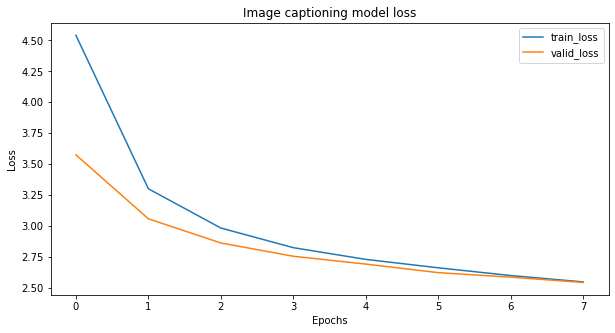

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="train_loss")
plt.plot(valid_loss_history, label="valid_loss")
plt.legend(loc='best')
plt.title("Image captioning model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Inseption и получение результатов


In [26]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети

from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [27]:
def generate_caption(image, num_of_captions=5, topk=3):
    network.eval()
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        captions = []
        img = image.copy()
        for _ in range(num_of_captions):
            image = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
            vectors_8x8, vectors_neck, logits = inception(image[None])

            output = network.sample(vectors_neck.cuda(), topk=topk)

            caption = ''
            for token in output:
                caption += vocab.to_word(token) + ' ' 
            captions.append(caption)
        return captions

### Скачаем пару картинок, чтобы проверить качество:

--2021-02-07 08:59:41--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-02-07 08:59:41--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.001s  

2021-02-07 08:59:41 (62.8 MB/s) - ‘img.jpg’ saved [54731

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


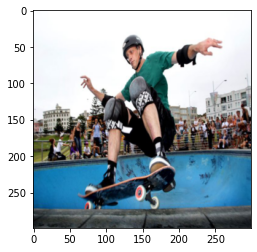

In [28]:
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)

In [29]:
captions = generate_caption(img, topk=2)

for caption in captions:
    print(caption)

a skateboarder doing a jump on a skate park . 
a skateboarder doing a jump in the air . 
a skateboarder doing tricks in the air on his skateboard . 
the man is doing a jump on a skate board . 
a man riding a skateboard down a ramp in a park 


--2021-02-07 08:59:53--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 146.20.65.28
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-02-07 08:59:53--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|146.20.65.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.006s  

2021-02-07 08:59:53 (17.5 MB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


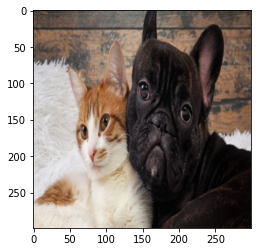

In [30]:
#sample image
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)

In [31]:
captions = generate_caption(img, topk=3)

for caption in captions:
    print(caption)

two black and black dogs sitting on the couch 
the cat is laying in a chair next for the window . . 
a cat laying in front with a cat in the back . 
the black and black dog laying down on top . a chair . 
a black cat with its head out a car 


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

Для каждого изображения в батче test_loader генерируем описание

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


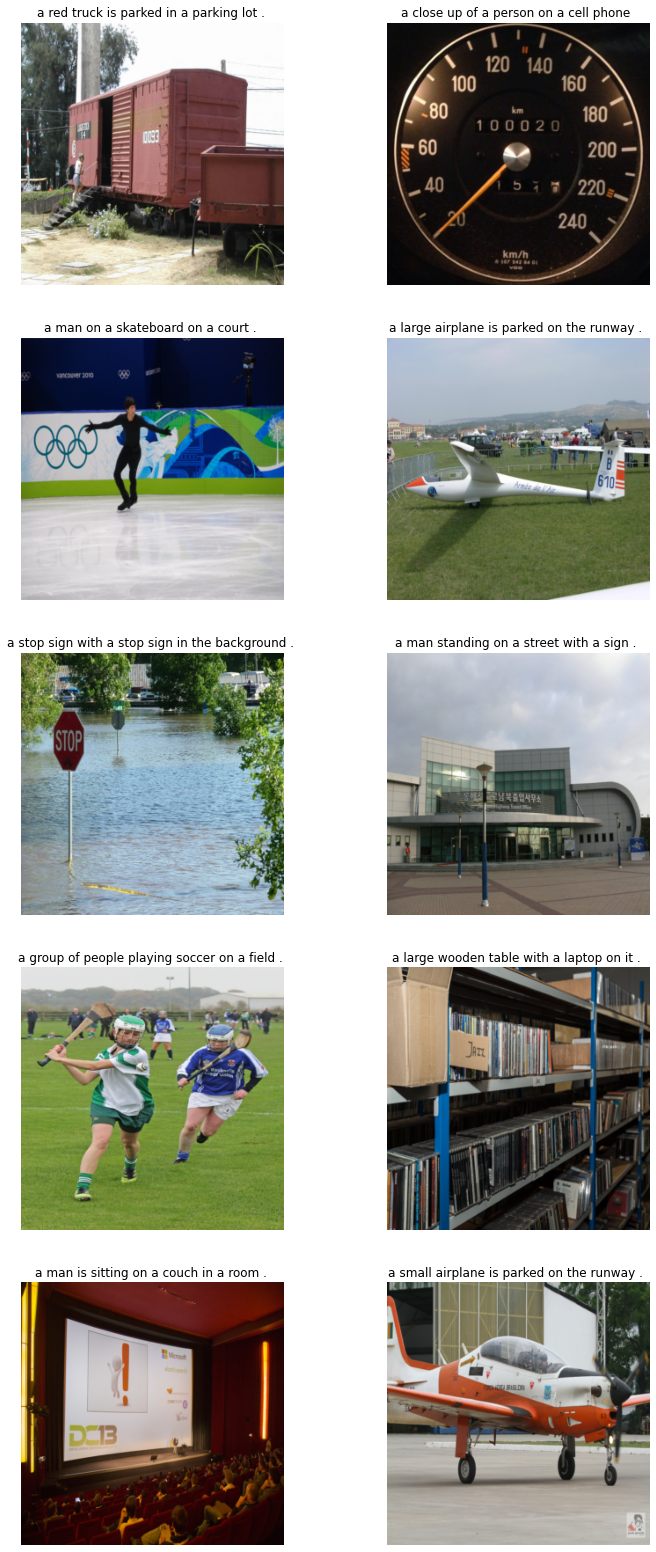

In [35]:
for images in test_loader:
    batch_size = images.size(0)
    plt.figure(figsize=(12,28))
    for i in range(batch_size):
        caption = generate_caption(images[i].numpy(), num_of_captions=1, topk=1)[0]
        plt.subplot(5,2,i+1)
        plt.axis('off')
        plt.title(caption)
        plt.imshow(images[i].numpy())
    break

Для проверки работоспособности сети на картинках, которые находятся на компьютере

In [45]:
from google.colab import files
uploaded = files.upload()

Saving 651e065e056bf51bdbe5a709fccc6c02.jpg to 651e065e056bf51bdbe5a709fccc6c02.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


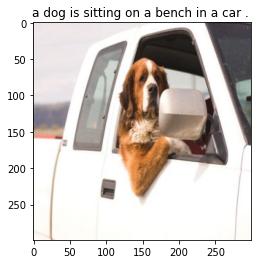

In [53]:
img = plt.imread('651e065e056bf51bdbe5a709fccc6c02.jpg') # change name if needed
img = imresize(img, (299, 299)).astype('float32') / 255.
caption = generate_caption(img, num_of_captions=1, topk=1)[0]

plt.title(caption)
plt.imshow(img)